In [16]:
import pandas as pd

df = pd.read_csv("./IMDB-Dataset.csv")
num_duplicates = df.duplicated().sum()

print(f"Số lượng mẫu trùng lặp: {num_duplicates}")
# Remove duplicate rows
df = df.drop_duplicates()

Số lượng mẫu trùng lặp: 418


In [8]:
df.head()

,review,sentiment
0,one reviewer mentioned watching oz episode hoo...,positive
1,wonderful little production filming technique ...,positive
2,thought wonderful way spend time hot summer we...,positive
3,basically family little boy jake think zombie ...,negative
4,petter matteis love time money visually stunni...,positive


Ở đây chúng ta sẽ thực hiện làm sạch dữ liệu thông qua các bước như: xoá thẻ html, xoá dấu câu,
xoá số, xoá các icon,...

In [17]:
import re
import string
import nltk
nltk.download('stopword')
nltk.download('wordnet')
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer # like better will change into good
from bs4 import BeautifulSoup #Scrape information from web pages
import contractions # Extend contractions like I'm -> I am

stop = set(stopwords.words('english'))

# Expanding contractions
def expand_contractions(text):
    return contractions.fix(text)

# Function to clean data
def preprocess_text(text):
    wl = WordNetLemmatizer()

    soup = BeautifulSoup(text, "html.parser") # Removing html tags
    text = soup.get_text()
    text = expand_contractions(text) 

    emoji_clean = re.compile(
                                "["
                                u"\U0001F600-\U0001F64F"  # emoticons
                                u"\U0001F300-\U0001F5FF"  # symbols & pictographs
                                u"\U0001F680-\U0001F6FF"  # transport & map symbols
                                u"\U0001F1E0-\U0001F1FF"  # flags (iOS)
                                u"\U00002702-\U000027B0"
                                u"\U000024C2-\U0001F251"
                                "]+", 
                                flags=re.UNICODE
                            )
    text = emoji_clean.sub(r'', text)  # Remove emojis
    text = re.sub(r'\.(?=\S)', '. ', text)  # Add space after full stop
    text = re.sub(r'http\S+', '', text)  # Remove URLs
    text = ''.join([
        word.lower() for word in text if word not in string.punctuation
    ])  # Remove punctuation and make text lowercase
    text = ' '.join([
        wl.lemmatize(word) for word in text.split() if word not in stop and word.isalpha()
    ])  # Lemmatize words, remove stopwords, and keep alphabetic words
    return text


df['review'] = df['review'].apply(preprocess_text)


[nltk_data] Error loading stopword: Package 'stopword' not found in
[nltk_data]     index
[nltk_data] Downloading package wordnet to /home/tan/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
/tmp/ipykernel_53885/3713504739.py:21: MarkupResemblesLocatorWarning: The input looks more like a filename than markup. You may want to open this file and pass the filehandle into Beautiful Soup.
  soup = BeautifulSoup(text, "html.parser") # Removing html tags


In [19]:
all_words = ' '.join(df['review']).split()
unique_words = set(all_words)
num_unique_words = len(unique_words)
print(f"Số lượng từ còn lại trong bộ từ điển: {num_unique_words}")

Số lượng từ còn lại trong bộ từ điển: 143307


## Phân tích dữ liệu:
Thống kê số lượng các nhãn trong bộ dữ liệu

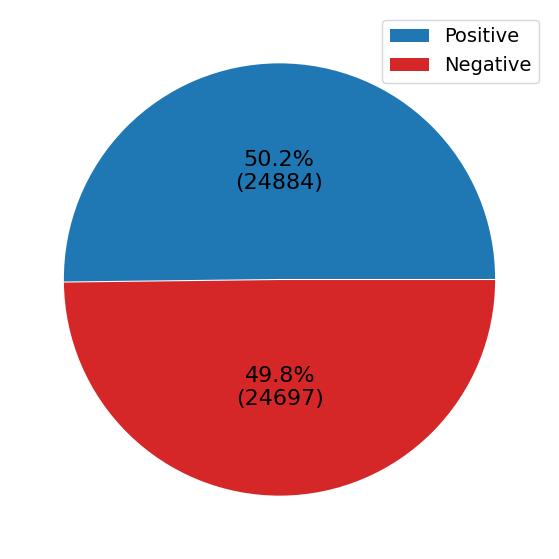

In [5]:
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Create autocpt arguments
def func(pct, allvalues):
    absolute = int(pct / 100. * np.sum(allvalues))
    return "{:.1f}%\n({:d})".format(pct, absolute)


freq_pos = len(df[df["sentiment"]=='positive'])
freq_neg = len(df[df["sentiment"]=='negative'])

data = [freq_pos, freq_neg]

labels = ['positive','negative']
# Create pie chart
pie, ax = plt.subplots(figsize = [11,7])

plt.pie(x = data, autopct = lambda pct: func(pct, data), explode=[0.0025]*2 , 
        pctdistance =0.5 , colors =[ sns.color_palette()[0] , 'tab:red'] , 
        textprops ={ 'fontsize': 16})

labels = [r'Positive', r'Negative']
plt.legend(labels, loc = "best", prop = {"size": 14})
pie.savefig("PieChart.png")
plt.show()

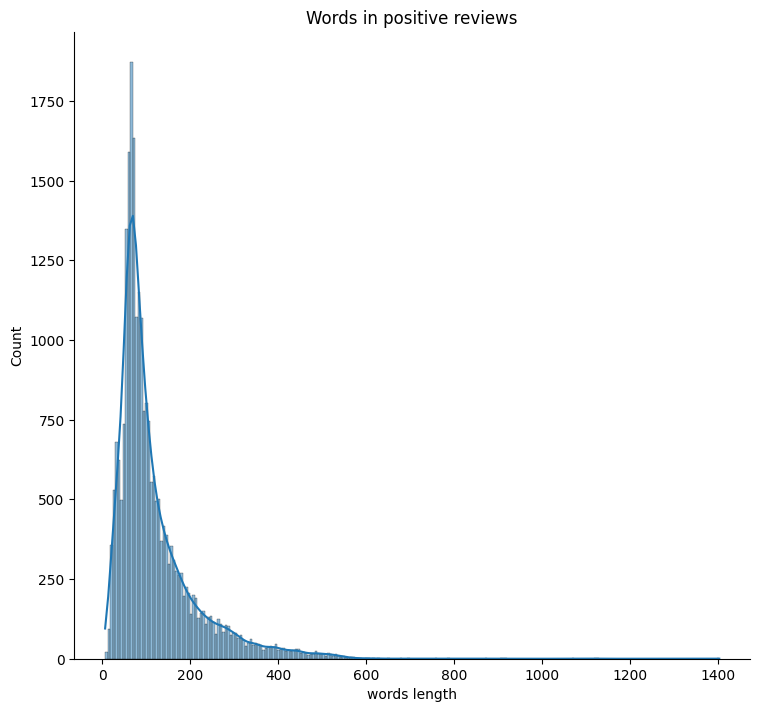

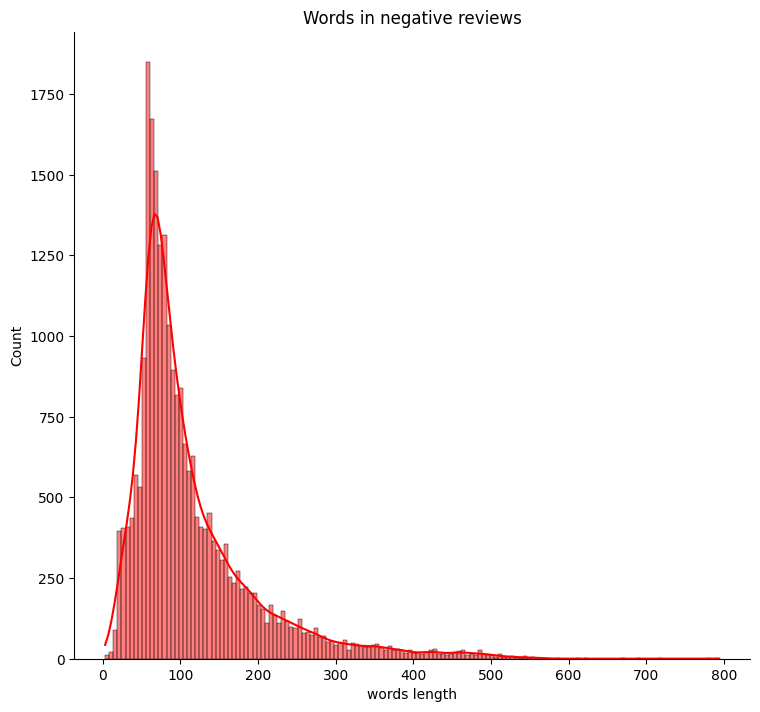

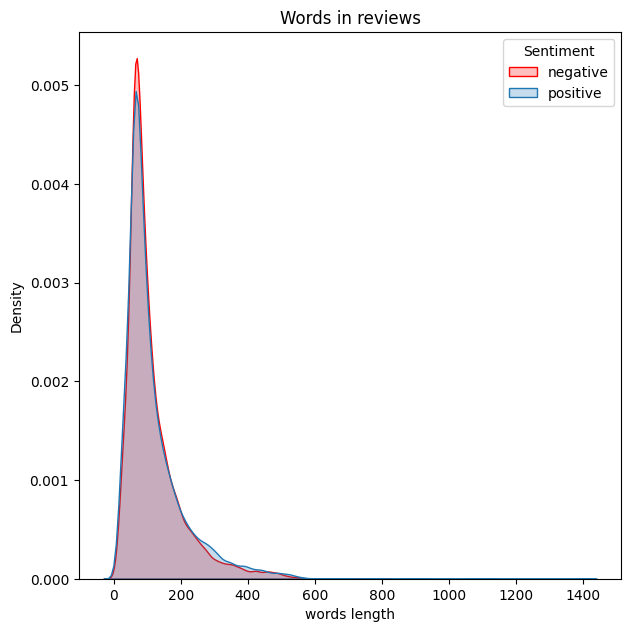

In [6]:
# Tính độ dài của các mẫu cho mỗi class
words_len = df['review'].str.split().map(lambda x: len(x))
df_temp = df.copy()
df_temp['words length'] = words_len

# Biểu đồ phân bố cho các review positive
hist_positive = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'positive'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False
).set(title='Words in positive reviews')

plt.show(hist_positive)

# Biểu đồ phân bố cho các review negative
hist_negative = sns.displot(
    data=df_temp[df_temp['sentiment'] == 'negative'],
    x="words length", hue="sentiment", kde=True, height=7, aspect=1.1, legend=False, palette=['red']
).set(title='Words in negative reviews')

plt.show(hist_negative)

# Biểu đồ phân bố KDE cho tổng số từ trong các review
plt.figure(figsize=(7, 7.1))
kernel_distribution_number_words_plot = sns.kdeplot(
    data=df_temp, x="words length", hue="sentiment", fill=True, palette=[sns.color_palette()[0], 'red']
).set(title='Words in reviews')

plt.legend(title='Sentiment', labels=['negative', 'positive'])
plt.show(kernel_distribution_number_words_plot)


## Chia tập train và test

In [7]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.preprocessing import LabelEncoder

In [10]:
label_encode = LabelEncoder()
y_data = label_encode.fit_transform(df['sentiment'])
x_data = df["review"]

x_train, x_test, y_train, y_test = train_test_split(x_data, y_data, test_size=0.2, random_state=42)

## Biểu diễn văn bản thành các vector

In [11]:
tfidf_vectorizer = TfidfVectorizer(max_features =10000)
tfidf_vectorizer.fit(x_train, y_train)

x_train_encoded = tfidf_vectorizer.transform(x_train)
x_test_encoded = tfidf_vectorizer.transform(x_test)

## Huấn luyện và đánh giá mô hình


In [12]:
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score

# Khởi tạo DecisionTreeClassifier
dt_classifier = DecisionTreeClassifier(
    criterion='entropy',
    random_state=42
)

# Huấn luyện mô hình
dt_classifier.fit(x_train_encoded, y_train)

# Dự đoán trên tập test
y_pred = dt_classifier.predict(x_test_encoded)

# Tính độ chính xác
accuracy = accuracy_score(y_test, y_pred)
print("Accuracy:", accuracy)


Accuracy: 0.715942321266512


In [13]:
rf_classifier = RandomForestClassifier (random_state =42)
rf_classifier.fit(x_train_encoded , y_train)
y_pred = rf_classifier.predict(x_test_encoded)
accuracy_score(y_pred, y_test)

0.8412826459614803